# Sequence-to-Sequence: Language Translation

In this assignment you will use a database of pairs of English and French sentences to train an RNN model to translate from English to French.

The English versions of the training sentences are in the file "small_vocab_en.txt" and their French translations are in "small_vocab_fr.txt". The $n$-th line of the English file corresponds to the $n$-th line of the French file. They are bundled with this starter notebook in the download on Canvas.  To get started, you should have used `scp` to copy the tar file to your Azure VM, and uncompressed it with:
```
tar zxf Seq-to-Seq-NL-Translation.tar.gz
```
to reveal the French and English training data and the starter notebook within, which you're presumably reading now.

**As in previous assignments, watch out for `TODO` and `QUESTION` marks in the notebook for cells containing pieces of code you need to complete, or cells where you should write answers in Markdown format.**

Some additional resources you might find helpful are listed below.

Keras resources: 
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html A quick discussion of using sequence-to-sequence methods in translation that corresponds well to what you do in this assignment.
* https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/ Has a nice review of the potentially confusing `return_states` and `return_sequences` options that some of our recurrent layer units have in Keras.
* https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563

Neural Language Translation Resources:
* https://arxiv.org/abs/1703.01619 This is a 65 page tutorial on NLP in the "just before Transformers" era.  You might find it useful to consult, or a good thing to set aside for enrichment reading after the course.

# Setup
## Imports

I don't think we've used anything from scikit-learn yet in the course,
so pop out to your terminal on the Azure VM, make sure your Conda 
environment with TensorFlow and friends installed is the currently active
environment, and install scikit-learn with:
```
conda install -c conda-forge scikit-learn
```

In [1]:
import math
import os
import string

import matplotlib.pyplot as plt

from IPython.display import SVG

# NOTE:
# It's worth reading through this list of imports to see how many of them
# feel familiar and comfortable at this stage of the course, and peeking at
# the documentation for any that seem new or less familiar.
#
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # ReduceLROnPlateau is new to us--check out its docs!
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

# Configuration Parameters for our Training Exercise

A bunch of configuration parameters we'll use later on in the notebook.  Skim through them and make sure they all ring the correct bells in your mind when you see them.  Watch for them to appear later.

In [2]:
TRAIN_TEST_SPLIT = 0.7           # % of data in training set

NUM_LSTM_NODES = 256             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 64
NUM_EPOCHS = 100

NUM_DATA_EXAMPLES = 5000         # limit memory usage

LR = 0.01
DROPOUT = 0.3

## Massaging Text

Remember that neural networks essentially just do almost linear algebra on multi-dimensional
arrays of numbers, with various non-linearities sprinkled in amongst them so that our networks
can learn to do more interesting things than pure matrix multiplication and vector addition could do.

Thus, we always need to mess with text to get it into a format presentable to a neural net.
What follows below is pretty close to the sort of stuff we discussed in class, but read through
it and sanity check the details for yourself before moving on to put it into use.

In [3]:
# The symbols Python strings consider to be 'punctuation' by default
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
def add_space_around_punctuation(s):
    result = ''
    for c in s:
        if c in string.punctuation and c != "'":
            result += ' %s ' % c
        else:
            result += c
    return result

### Helpers for Cleaning the Text, Adding Stop/Stop Symbols, Etc.

In [5]:
def clean_sentence(s):
    s = s.strip()
    s = s.lower()
    s = add_space_around_punctuation(s)
    return s

def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    words = list(filter(None, s.split(' ')))
    if reverse:
        words = words[::-1]
    if add_start_symbol:
        words = ['<S>'] + words
    if add_end_symbol:
        words.append('</S>')
    return words

def get_word_list_from_sentence_string(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    return get_words_from_sentence(clean_sentence(s), add_start_symbol, add_end_symbol, reverse)    
    
def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=False, reverse=False):
    with open(os.path.join(path, filename), 'r') as f:
        lines = f.readlines()
        return [get_word_list_from_sentence_string(s, add_start_symbol, add_end_symbol, reverse) 
                for s in lines]

def get_word_set(sentences):
    words = set()
    for s in sentences:
        for word in s:
            words.add(word)
    return words
            

### Load the Training Data Plus a Neat Translator Training Trick

In [6]:
# Load the training data files
PATH = '.'

# Below is a trick you might remember us mentioning in class.  If you reverse the words in the
# source text, the average distance between corresponding words in the source and target texts
# remains unchanged, *but* the first few words in the source language are now very close to the
# first few words in the target language.  In practice, LSTMs seem to learn better when we do
# this reversal before training.  The phenomenon is not, AFAIK, very rigorously understood,
# like many things in practical deep learning, but it may make the optimization problem easier
# by helping "establish communication" between the source sentence and the target sentence.
#
# For more details, see: https://arxiv.org/abs/1409.3215 
s1 = get_sentences(PATH, 'small_vocab_en.txt', reverse=True, add_end_symbol=False) # Reverse input sentences for training

s2 = get_sentences(PATH, 'small_vocab_fr.txt', add_start_symbol=True)

In [7]:
# Only get a subset of the data
s1 = s1[:NUM_DATA_EXAMPLES]
s2 = s2[:NUM_DATA_EXAMPLES]

In [8]:
w1 = list(get_word_set(s1))
w2 = list(get_word_set(s2))

In [9]:
for w in w1[:10]:
    print(w)
print()
for w in w2[:10]:
    print(w)

sometimes
june
it's
quiet
?
china
india
pears
march
chilly

déteste
quand
doux
fraise
?
verte
votre
pomme
détestez
californie


### Helper Functions for Going Between Words and Their Indices

In [10]:
def get_word_to_index_dict(words):
    return {w: i+1 for i,w in enumerate(words)}  # use i+1 to reserve 0 for the mask index
def reverse_dict(d):
    return {v: k for k,v in d.items()}

In [11]:
word_to_index1 = get_word_to_index_dict(w1)
word_to_index2 = get_word_to_index_dict(w2)
index_to_word1 = reverse_dict(word_to_index1)
index_to_word2 = reverse_dict(word_to_index2)
index_to_word1[0] = '<MASK>'
index_to_word2[0] = '<MASK>'

In [12]:
def sentence_to_indices(s, word_to_index):
    return [word_to_index[w] for w in s]

In [13]:
def indices_to_sentence(indices, index_to_word):
    return [index_to_word[i] for i in indices]

In [14]:
x = sentence_to_indices(get_word_list_from_sentence_string('vous aimez raisins.', add_start_symbol=True), word_to_index2)
x

[277, 225, 66, 173, 184]

In [15]:
indices_to_sentence(x, index_to_word2)

['<S>', 'vous', 'aimez', 'raisins', '.']

## Prepare Training and Test Sets

In [16]:
num_words_X = len(w1) + 1  # add 1 to reserve 0 for mask
num_words_y = len(w2) + 1  # add 1 to reserve 0 for mask
num_words_X, num_words_y

(197, 309)

In [17]:
inputs_as_indices = [sentence_to_indices(s, word_to_index1) for s in s1]
outputs_as_indices = [sentence_to_indices(s, word_to_index2) for s in s2]

In [18]:
inputs = pad_sequences(inputs_as_indices)
outputs = pad_sequences(outputs_as_indices, padding='post')

In [19]:
max_seq_len_X = len(inputs[0])
max_seq_len_y = len(outputs[0])
max_seq_len_X, max_seq_len_y

(17, 23)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, 
                                                    test_size=1 - TRAIN_TEST_SPLIT,
                                                    random_state=42)

In [21]:
# We need to one-hot-encode the outputs ourselves for use in the loss function. 
# The inputs get this for free via use of Embedding layers in Keras.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [22]:
# Eyeball the shapes of the training and test sets...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 17), (1501, 17), (3499, 23), (1501, 23))

# Create Model

Now we need to write code to build the SeqToSeq model. 

**Important**: In Keras we have to use the "functional API" in order to access the LSTM internal state that we use as the "context vector" or "encoding" of a sentence. We also need to store hooks into the model to be able to run the translator on new sentences after training.

This code will create variables representing the entire SeqToSeq model (for use in training), as well as the individual encoder segment and decoder segment of the model, for use in inference.

## Encoder

We will implement the following architecture:
    
1. Encoder input: shape (max_seq_len_X,)
2. Masking layer: doesn't change shape. Ignores leading "-1"s in shorter sequences.
3. Embedding layer: output shape (max_seq_len_X, EMBEDDING_DIM)
4. LSTM layer 1. N.B. The first LSTM layer in a stack must use "return_sequences=True"
5. LSTM layer 2. N.B. The final layer must use "return_state=True" so we can extract the internal state (the context vector).

In [24]:
# Build RNN model.
# See also: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/

encoding_size = CONTEXT_VECTOR_SIZE
max_input_seq_len = max_seq_len_X
max_output_seq_len = max_seq_len_y
num_input_words = num_words_X
num_output_words = num_words_y

# TODO: Set up encoder Input layer
encoder_inputs = Input(shape=(max_input_seq_len,), name='encoder_input')

# TODO: Set up Masking layer--if you're forgetting what Masking is about, consult the Keras docs and/or the lecture
encoder_inputs_masked = Masking(name='encoder_masking')(encoder_inputs)

# TODO: Set up word Embedding layer we'll train
encoder_inputs_embedded = Embedding(num_input_words, EMBEDDING_DIM, name='encoder_embedding')(encoder_inputs_masked)

# Set up the first LSTM layer
encoder_outputs0 = LSTM(NUM_LSTM_NODES, return_state=True, return_sequences=True, name='encoder_lstm_0')
encoder_output0, state_h0, state_c0  =  encoder_outputs0(encoder_inputs_embedded)

# Set up the second LSTM layer
encoder_outputs1 = LSTM(NUM_LSTM_NODES, return_state=True, return_sequences=False, name='encoder_lstm_1')
encoder_outputs1, state_h1, state_c1 = encoder_outputs1(encoder_output0)

# Discard `encoder_outputs2` and only keep the states.
encoder_states1 = [state_h1, state_c1]

## Decoder

### The decoder should have the following architecture:
    
1. Decoder input: shape (max_seq_len_y,)
2. Masking layer: doesn't change shape. Ignores final "-1"s in shorter sequences.
3. Embedding layer: output shape (max_seq_len_y, EMBEDDING_DIM)
4. LSTM layer 1. N.B. The first LSTM layer in a stack must use "return_sequences=True", and the final layer must use "return_state=True" so we can extract the internal state; this decoder has only one LSTM layer so you'llmake both True.
6. Dense layer with softmax: output shape (num_output_words,)

In [25]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.

# TODO: Set up Input layer as described above
decoder_inputs = Input(shape=(max_output_seq_len,), name='decoder_input')
# TODO: Set up Masking layer as described above
decoder_inputs_masked = Masking(name='decoder_masking')(decoder_inputs)
# TODO: Set up Embedding layer as described above
decoder_inputs_embedded = Embedding(num_output_words, EMBEDDING_DIM, name='decoder_embedding')(decoder_inputs_masked)

# TODO: Create LSTM layer as described above
decoder_lstm = LSTM(NUM_LSTM_NODES, return_sequences=True, return_state=True, name='decoder_lstm_1')

# TODO: Get output of decoder layer you created above---it must consume the decoder_inputs_embedded and take the final encoder_states saved earlier as its initial_state
z, _, _ = decoder_lstm(decoder_inputs_embedded, initial_state=encoder_states1)

# TODO: Set up Dense layer as described above
decoder_dense = Dense(num_output_words, activation='softmax', name="dense_output")

decoder_outputs = decoder_dense(z)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

### Put it all together into one model, and visualize

The final model will use as its inputs a list containing:
- the encoder inputs
- the decoder inputs

And a use as its outputs:
- the decoder outputs

In [26]:
# TODO: Build the model, passing the arguments as described above...
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 17)]         0           []                               
                                                                                                  
 encoder_masking (Masking)      (None, 17)           0           ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 17, 100)      19700       ['encoder_masking[0][0]']        
                                                                                              

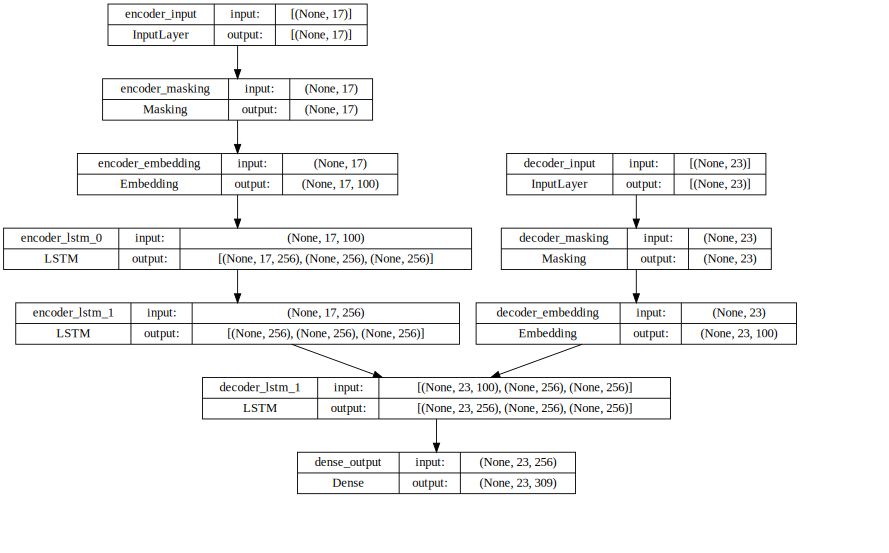

In [27]:
# Visualize the model and sanity check it...
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [28]:
encoder_input_data = X_train

In [29]:
decoder_input_data = y_train

In [30]:
# decoder_target_data will be ahead by one timestep
# and will not include the start token.
decoder_target_data = np.zeros(y_train_one_hot.shape)
decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]

In [31]:
decoder_target_data_test = np.zeros(y_test_one_hot.shape)
decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

In [32]:
print(encoder_input_data[0], decoder_input_data[0], decoder_target_data[0])
print(decoder_input_data[0][:2], decoder_target_data[0][:1])

print(encoder_input_data.shape, decoder_input_data.shape, 
      decoder_target_data.shape)

[  0   0  69 185  33  91  93 124 107  87  88  65  13  93 177  56  17] [277 287  58 300 122 252  12 289 251 186 178 272 266 289 214 184   0   0
   0   0   0   0   0] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[277 287] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0

In [33]:
# TODO: Set optimizer to be the Adam optimizer with a learning rate of .001
optimizer = Adam() # default learning rate is 0.001

# TODO: Compile the model using the optimizer you created above and the categorical cross-entropy loss
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [34]:
# NOTE: We've used various callbacks before to do things like early stopping, and model
#       checkpointing, and we've mentioned that sometimes you want to dynamically change
#       the learning rate over time, taking big steps at first, and smaller ones later,
#       when you may be closer to the target.  The callback below reduces the learning
#       rate when a metric has stopped improving---when learning seems to be stalling out,
#       shrinking the learning rate by a healthy factor can help zero in on the optimum.
#
#       Consult the Keras docs on `ReduceLROnPlateau` and answer the question below.
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto', 
                                cooldown=0, min_lr=0)

# QUESTION: Understanding `ReduceLROnPlateau`

In your own words, describe what `ReduceLROnPlateau` does and why you might want to use it.

# ANSWER:

Reduces learning rate by monitoring a metric like accurary or in our case, the validation loss. If the metric isn't improving after a user specified number of epochs or patience, ReduceLROnPlateau reduces learning rate by a user specified factor which in our case will reduce by half.

In [35]:
# If you've forgotten the details of how the `EarlyStopping` callback works, or if you've forgotten
# the general idea, consult the http://keras.io documentation on it to refresh your memory.
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [36]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=([X_test, y_test], decoder_target_data_test),
          callbacks=[lr_callback, early_stopping_callback])

# You might want to watch the training output for the moments where the
# learning rate drops due to the effects of the ReduceLROnPlateau callback,
# to appreciate what the callback is trying to do for you.

Epoch 1/100
55/55 [==============================] - 22s 306ms/step - loss: 3.1713 - val_loss: 2.5054 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 14s 256ms/step - loss: 2.2958 - val_loss: 2.0595 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 14s 248ms/step - loss: 1.8043 - val_loss: 1.5536 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 14s 249ms/step - loss: 1.3727 - val_loss: 1.2099 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 14s 264ms/step - loss: 1.1036 - val_loss: 1.0164 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 13s 244ms/step - loss: 0.9573 - val_loss: 0.8984 - lr: 0.0010
Epoch 7/100
55/55 [==============================] - 16s 287ms/step - loss: 0.8723 - val_loss: 0.8426 - lr: 0.0010
Epoch 8/100
55/55 [==============================] - 14s 261ms/step - loss: 0.8176 - val_loss: 0.7928 - lr: 0.0010
Epoch 9/100
55/55 [==============================] - 14s 248ms/step - loss: 0.77

In [37]:
# Save model
model.save('s2s.keras')

# Inference

We have trained a model, but how do we use it to actually translate sentences? We have to do more work ourselves here than with a non-recurrent neural net, so we'll write a function to help out. Here are the steps:

1. **Encode**:
    1. Run the entire input sentence through the encoder part of the model.
    1. Write down the "context vector" -- this is the state of the last LSTM encoder layer.<br><br>

2. **Decode in a loop**:
    1. Seed the decoder LSTM with the context vector.
    1. Run a *single step* of the decoder with the input "`<S>`" (the start symbol).
    1. Store the output. This is a word of the translation!
    1. Return to step 2B, but feed in the word from step 2C as the new input. Repeat until the decoder returns "`</S>`" (the end symbol).

## Attention!
At this point you should work through the following cells, and make sure you understand the
set up we're doing.  It will make following the logic of the translate function a lot easier
at the end of the notebook.

In [38]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states1)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 17)]              0         
                                                                 
 encoder_masking (Masking)   (None, 17)                0         
                                                                 
 encoder_embedding (Embeddin  (None, 17, 100)          19700     
 g)                                                              
                                                                 
 encoder_lstm_0 (LSTM)       [(None, 17, 256),         365568    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 encoder_lstm_1 (LSTM)       [(None, 256),             525312    
                              (None, 256),                 

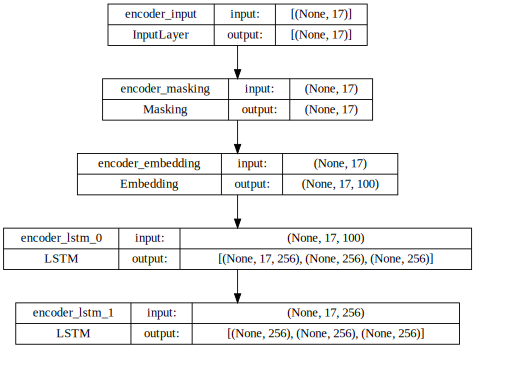

In [39]:
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [40]:
# NOTE: Make sure you see how states are interacting between encoder
#       and decoder here...  the model visualizations and talking
#       through what they do may be illuminating.

decoder_state_input_h = Input(shape=(NUM_LSTM_NODES,))
decoder_state_input_c = Input(shape=(NUM_LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs1, state_h1, state_c1 = decoder_lstm(decoder_inputs_embedded, initial_state=decoder_states_inputs)

decoder_states1 = [state_h1, state_c1]
decoder_outputs = decoder_dense(decoder_outputs1)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states1)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 decoder_masking (Masking)      (None, 23)           0           ['decoder_input[0][0]']          
                                                                                                  
 decoder_embedding (Embedding)  (None, 23, 100)      30900       ['decoder_masking[0][0]']        
                                                                                                  
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

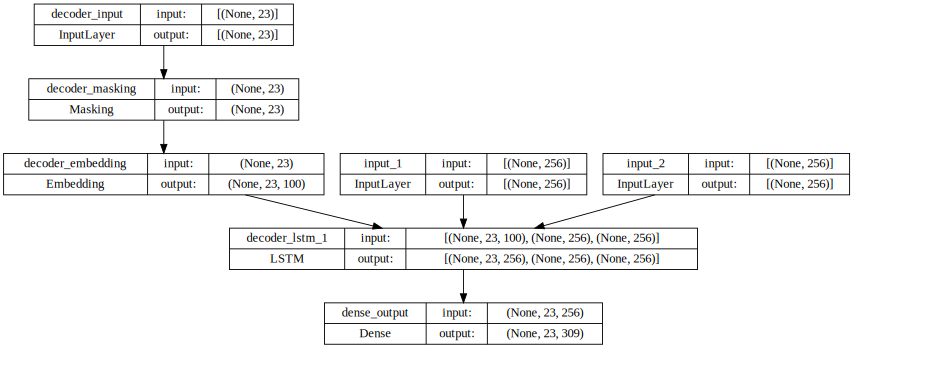

In [41]:
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

# Translating Sequences

The `translate_sequence` method works as described above, but its internals may seem a bit
gnarly and complicated because it has to deal with:
- getting the hidden and internal states of the encoder model
- generating a container for the target/output sequence and pre-populating it with the start symbol
- looping to call the decoder to make a prediction given the target sequence so far + the encoder's passed on states
- picking apart the output, which you recall is a softmax the width of the vocabulary with each entry being the probability that the corresponding word comes next
- convert word indices back to words and accumulating them into the translation so far
- and figuring out when to stop.

Because it's so easy to get little things wrong in such a loop, it's provided without requiring you to add anything.
You'll probably benefit most from it, if you get it started running, and then start picking apart the code line by
line, making sure you understand:
- how it relates to the encoder and decoder networks you built up above
- the details of how it's converted predicted probabilities into word vectors and in turn into words
- the general looping structure used to make the decoder feed itself its own output repeatedly and build a growing translated output

Understanding a thing like this function is one place where notebooks are kind of crappy.  It can be a lot
more illuminating to single step through the function in a debugger and see what it's doing at each step,
and how states are mutating.

In [42]:
def translate_sequence(input_seq):
    # Encode the input as state vectors.
    h1, c1 = encoder_model.predict(input_seq)
    states_value1 = [h1, c1]
    # Generate empty target sequence of length 1 (one-hot encoded).
    #target_seq = np.zeros((1, num_output_words))
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start symbol.
    #target_seq[0, word_to_index2['<S>']] = 1.
    target_seq[0,0] = word_to_index2['<S>']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    step = 0
    while not stop_condition:
        #print('step:', step)
        #print(states_value1[0][0][0:5])
    
        output_tokens, h1, c1  = decoder_model.predict(
            [target_seq] + states_value1)

        # Sample a token
        #print(output_tokens)
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = index_to_word2[sampled_token_index]
        #print(sampled_word)
        decoded_sentence += sampled_word + ' '
        step += 1
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '</S>' or step > max_output_seq_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, num_output_words))
        #target_seq[0, sampled_token_index] = 1.
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value1 = [h1, c1]

    return decoded_sentence

In [43]:
# Look at some translations...  Note we may well produce translations that are not the
# very same ones seen in the test set!
for i in range(10):
    print(indices_to_sentence(X_test[i], index_to_word1)[::-1])
    print(translate_sequence(np.expand_dims(X_test[i], axis=0)))

['my', 'most', 'loved', 'fruit', 'is', 'the', 'banana', ',', 'but', 'their', 'most', 'loved', 'is', 'the', 'orange', '.', '<MASK>']
1/1 [==============================] - 0s 48ms/step
mon fruit le plus aimé est la banane , mais leur plus aimé est l'orange . <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> 
['she', 'likes', 'apples', ',', 'oranges', ',', 'and', 'strawberries', '.', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']
1/1 [==============================] - 0s 72ms/step
elle aime les pommes , les oranges et les fraises . <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> 
['the', 'banana', 'is', 'our', 'least', 'favorite', 'fruit', ',', 'but', 'the', 'grape', 'is', 'their', 'least', 'favorite', '.', '<MASK>']
1/1 [==============================] - 0s 76ms/step
la banane est notre fruit préféré moins , mais le raisin est leur moins préféré . <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> 
['

# QUESTION: How Good Are These Results?

1. Do you speak or read French at all?  If so, how well?
2. How do these translations look to you, if you know enough French to evaluate them?

# ANSWER:

I don't speak or read French. I used Google to translate the French result. 
As per Google for the input: la chine est parfois froid au mois d' août , mais il est généralement merveilleux en janvier,
this is the output: China is sometimes cold in August, but it is usually wonderful in January.
So the model isn't doing well.

In [44]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1516242594570646706
xla_global_id: -1
]
